## Recreate DQN model from Deepmind Atari paper

References:   
Paper: https://arxiv.org/pdf/1312.5602.pdf    
Pytorch tutorial: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [1]:
# import relevant packages
import torch
from collections import namedtuple, deque
import random
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import gym
import pandas as pd
import numpy as np
import cv2

### Experience Replay   
Data structure to store past experiences and sample some examples for training, the idea is to ***"alleviate the problems of correlated data and non-stationary distributions"***

In [2]:
# Use named tuple to represent Experience referred in paper
Experience = namedtuple('Experience', ["state", "action", "reward", "successor", "done"])

class ReplayMemory():
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        """add new experience"""
        self.memory.append(Experience(*args))
        
    def sample(self, batch_size):
        """randomly sample experiences from Replay Memory"""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """Override default len() method"""
        return len(self.memory)

### Training Model  
Build model based on the paper's description 
> The input to the neural network consists is an 84 × 84 × 4 image produced by φ. The first hidden layer convolves **16 8 × 8 filters with stride 4** with the input image and applies a **rectifier nonlinearity**. The second hidden layer convolves **32 4 × 4 filters with stride 2**, again followed by a **rectifier nonlinearity**. The final hidden layer is fully-connected and consists of **256 rectifier units**. The output layer is a fully- connected linear layer with a **single output for each valid action**.

In [3]:
class DQN_model(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN_model, self).__init__()
        self.layer1 = nn.Conv2d(input_shape[0], 16, kernel_size=(8,8), stride=4)
        self.layer2 = nn.Conv2d(16, 32, (4,4), stride=2)
        # output shape after EACH convo would be ((dimension - filter size)/stride +1) **2 (for 2 sides)
                                                                            # * 4 (stack) * output_channel
        dim_size = (((84-8)/4 + 1)-4)/2+1
        self.layer3 = nn.Linear(int((dim_size)**2 * 32), 256)
        self.output = nn.Linear(256, n_actions) 
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.layer3(x))
        x = self.output(x)
        
        return x

### Prepare environment   
The paper specifies several preprocessing steps to apply to the raw frames
>210 × 160 pixel images with a 128 color palette, can be computationally demanding, so we apply a basic preprocessing step aimed at reducing the input dimensionality. The raw frames are preprocessed by first converting their RGB representation to **gray-scale** and **down-sampling it to a 110×84 image**. The final input representation is obtained by cropping an 84 × 84 region of the image that roughly captures the playing area.

Using gym, we can apply **GrayScaleObservation** wrapper to get gray-scale representation, and instead of cropping to game play section, a **resize wrapper** is applied

<br>

> For the experiments in this paper, the function φ from algorithm 1 applies this preprocessing to the **last 4 frames of a history and stacks them** to produce the input to the Q-function.

For this, we can apply **FrameStack** wrapper to get a stacks of 4 frames

<br>

> Since the scale of scores varies greatly from game to game, we fixed all positive rewards to be 1 and all negative rewards to be −1, leaving 0 rewards unchanged.


Lastly, we can apply **ClipReward** wrapper to crop reward to specified range
<br>

Observation shape:  (4, 84, 84)


A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


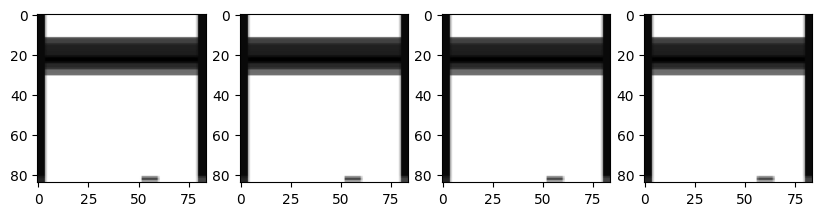

In [4]:
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack
from gym.utils.env_checker import check_env

# Wrapper to clip reward, taken from documentation
class ClipReward(gym.RewardWrapper):
    def __init__(self, env, min_reward, max_reward):
        super().__init__(env)
        self.min_reward = min_reward
        self.max_reward = max_reward
        self.reward_range = (min_reward, max_reward)
    
    def reward(self, reward):
        return np.clip(reward, self.min_reward, self.max_reward)
    
# observation wrapper for cropping
class AtariCropping(gym.ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        super().__init__(env)
        
        old_shape = env.observation_space.shape
        # get new shape after cropping
        new_shape = (old_shape[0]-50,) + old_shape[1:]
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=new_shape)

    def observation(self, img):
        """what happens to each observation"""
        # crop image (top and bottom, top from 34, bottom remove last 16)
        img = img[34:-16, :, :]
              
        return img

def generate_env(env_name):
    env = gym.make(env_name)
    env = ClipReward(env, -1, 1)
    env = AtariCropping(env)
    # gray scale frame
    env = GrayScaleObservation(env, keep_dim=False)
    # resize frame to 84×84 image
    env = ResizeObservation(env, (84, 84))
    # stack 4 frames (equivalent to what phi does in paper) 
    env = FrameStack(env, num_stack=4)
    
    return env
    
env = generate_env("Breakout-v4")
env.reset()
observation, reward, done, _ = env.step(env.action_space.sample())
print("Observation shape: ", env.observation_space.shape)

# visualize frames in each step 
_, axs = plt.subplots(1, 4, figsize=(10,10))
for i, image in enumerate(observation):
    axs[i].imshow(image, cmap=plt.cm.binary)
plt.show()

### Function to determine action
Apply $\epsilon$ greedy algorithm to choose action   
* Choose random action at probability $\epsilon$
* Choose optimal action (determined by model) at probability (1-$\epsilon$)

In [9]:
import random

def choose_action(model, state, device, epsilon=0.1):
    if random.random()<=epsilon: #exploration
        return env.action_space.sample()
    else:
#         squeeze to remove last dim of 1 (for gray scaled val) and add 1 dim at first (1 input instead of batch)
        state = torch.Tensor(state).squeeze().unsqueeze(0).to(device)
        # predict
        pred = model(state)
        return int(torch.argmax(pred.squeeze()).item())

### Loss function  
As mentioned in the paper, the function to optimize would be the following
> $$L_i(θ_i) = E_{s,a∼ρ(·)} [(y_i − Q (s, a; θ_i))]^2 $$
> where: $$y_i = E_{s′∼\mathcal{E}} [r + γ max_{a′} Q(s′, a′; θ_{i−1})|s, a]$$

Notation translation:
- θ refers to weights of model, $θ_i$ refers to model (with weights) at iteration i
- $Q (s, a; θ_i)$ (prediction) is Q value at (s, a) estimated by model
- $y_i$ (target function) is calculated using Bellman equation, but future reward (aka Q(s', a')) is (again) estimated by the model

Code translation:
- $Q (s, a; θ_i)$ is calculated by plug in state for model to predict, and get the output at action a (state and action sampled from experience replay)
- $max_{a′} Q(s′, a′; θ_{i−1}$ in $y_i$ is calculated by plug in successor state, then get the max output out of all actions
- loss is square root of $y_i$ (expected Q) - $Q (s, a; θ_i)$ (prediction)

In [10]:
def loss_fn(model, replay_memory, batch_size, discount, target_model=None, device="mps"):
    batch = replay_memory.sample(batch_size)

#     Transpose batch, ref: https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip/19343#19343
    batch = Experience(*zip(*batch))
    
#     convert to a single np.array for faster tensor conversion
    state = np.array(batch.state)
    successor = np.array(batch.successor)
            
    # Tensor-ify state, action, reward, successor, done (use torch tensor to have grad)
    state = torch.Tensor(state).squeeze().div_(255).to(device)
    action = torch.Tensor(batch.action).to(device)
    reward = torch.Tensor(batch.reward).to(device)
    successor = torch.Tensor(successor).squeeze().to(device)
    done = torch.tensor(batch.done, dtype=torch.int32).to(device)

    # use model to get old qs and successor qs
    old_qs = model(state)
    # if target model is provided -> use that to compute successor instead
    successor_qs = model(successor) if target_model is None else target_model(successor) 
    
#   check for exploding/diminissing problem
#     print(torch.isnan(old_qs).any())
        
    # get the list of actions in shape 1xbatch_size, and use it as indices for old_qs
    action = action.unsqueeze(1).type(torch.int64)
    # get predicted qs at action, return tensor of list of batch_size items
    old_qs = old_qs.gather(1, action).squeeze()
    # get max q in successor to estimate future reward
    successor_qs = successor_qs.max(1)[0]
            
    # compute expected qs
    # multiplying (1-done) would result in not adding future reward when at end state (done==1)
    expected_qs = reward + successor_qs*discount*(1-done)
        
    # compute loss, return mean loss of batch 
    loss = (expected_qs - old_qs).pow(2).mean()
    
#     print("Old Qs ", old_qs)
#     print("Expected Qs ", expected_qs)
#     print("Loss ", loss.item())
    
    
    # improvement for stability - use different loss 
    # loss_func = nn.HuberLoss()
    # loss = loss_func(old_qs, expected_qs)
    
    # return predicted qs for visualization
    return loss, old_qs

### Hyper parameters

In [11]:
ENV = "BreakoutDeterministic-v4"
LEARNING_RATE = 0.00001 if ENV == "BreakoutDeterministic-v4" else 0.00025
REPLAY_LEN = 1000000
BATCH_SIZE = 32
EPISODES = 16000
DISCOUNT = 0.99 #aka gamma in Bellman's equation
SAVE_FREQ = 50 #number of episodes in-between saves
START_EPSILON= 1
END_EPSILON= 0.1
DECAY_FRAMES=1000000
USE_TARGET_MODEL=False # whether to have target model or not
UPDATE_TARGET=1000 #frames to run before updating the target model

### Setting up variables before training

In [12]:
# check for mps, cuda or cpu
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")
model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
target_model = None
if USE_TARGET_MODEL:
    target_model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
    target_model.load_state_dict(model.state_dict())

# optimizer based on paper
# optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

# optimizer for first training (not-so-happy accident =)))
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# recommended (less computational heavy compared to RMSprop)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
# array to store info per episodes
episodes = []
losses = []
rewards = []
pred_qs = []

# count to keep track of episodes and frames (for epsilon decay)
count = 0
frames = 0

# build env
env = generate_env(ENV)
print(f"Current Atari environment: {ENV}")
print(f"Learning rate: {LEARNING_RATE}")

# Initialize replay memory with len of replay buffer
curr_state = env.reset()
curr_state = np.asarray(curr_state) #convert to np array
replay_memory = ReplayMemory(capacity=REPLAY_LEN)
for i in range(BATCH_SIZE):
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)
    
    observation = np.asarray(observation) #convert to np array
    replay_memory.push(curr_state, action, reward, observation, done)
    
    # update curr state
    curr_state = observation
    
print(f"Initial length of replay memory: {len(replay_memory)}")

Device: mps
Current Atari environment: BreakoutDeterministic-v4
Initial length of replay memory: 32


### Training process

In [ ]:
# main training loop
for i in range(EPISODES):
    curr_state = env.reset()
    curr_state = np.asarray(curr_state) #convert to np array
    loss_val = 0
    reward_val = 0
    pred_q_val = 0
    # keep track of actions chosen during episode
    action_count = {i:0 for i in range(env.action_space.n)}
    
    while True:
        # decay over the first million frames then stay at 0.1
        decay = (DECAY_FRAMES - frames)/DECAY_FRAMES if frames < DECAY_FRAMES else 0
        epsilon = END_EPSILON + decay*(START_EPSILON-END_EPSILON)
        action = choose_action(model, curr_state, device, epsilon=epsilon)
        # execute action
        observation, reward, done, _ = env.step(action)
        observation = np.asarray(observation) #convert to np array
        # save observation
        replay_memory.push(curr_state, action, reward, observation, done)
        
        # update curr_state
        curr_state = observation
        
        # sample and compute loss
        loss, pred_q = loss_fn(model, replay_memory, BATCH_SIZE, DISCOUNT, target_model=target_model, device=device)
        
        # zero out gradient before backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if frames%200==0:
            # print loss and reward every 200 frames
            print(f"Frame:{frames} Action {action} Loss: {round(loss.item(),5)} Reward: {reward} Epsilon: {epsilon}")
        
        # update target model if available
        if USE_TARGET_MODEL:
            if frames%UPDATE_TARGET:
                target_model.load_state_dict(model.state_dict())
        
        # add frames count for epsilon decay
        frames+=1
        
        # update total reward of episode
        reward_val += reward
        
        # update loss as the max loss during episode
        loss_val = max(loss.item(), loss_val)
        
        # update predicted q in training
        pred_q_val = max(pred_q.mean().item(), pred_q_val)
        
        # update action count
        action_count[action]+=1
        
        if done: 
#             loss_val = loss.item()
            count+=1
            # finish an episode
            break
    print(f"Done with episode {count} in {frames} frames")
    print(f"Loss: {loss_val} Episode total reward: {reward_val} Predicted Qs: {pred_q_val}")
    print("Actions chosen counts: ", action_count)
    print("----------------")
    if count%SAVE_FREQ==0:
        episodes.append(count)
        losses.append(loss_val)
        rewards.append(reward_val)
        pred_qs.append(pred_q_val)
        
print("FINISH TRAINING PROCESS")
print(f"Finish in {frames} frames, Highest reward {max(rewards)}")

Frame:0 Action 1 Loss: 6.07483 Reward: 0.0 Epsilon: 1.0
Done with episode 1 in 157 frames
Loss: 6.074832916259766 Episode total reward: 1.0 Predicted Qs: 0.03268670290708542
Actions chosen counts:  {0: 39, 1: 36, 2: 42, 3: 40}
----------------
Frame:200 Action 1 Loss: 0.00252 Reward: 0.0 Epsilon: 0.99982
Done with episode 2 in 290 frames
Loss: 0.024869341403245926 Episode total reward: 0.0 Predicted Qs: 0.02806287631392479
Actions chosen counts:  {0: 27, 1: 38, 2: 42, 3: 26}
----------------
Frame:400 Action 0 Loss: 0.00188 Reward: 0.0 Epsilon: 0.9996400000000001
Done with episode 3 in 457 frames
Loss: 0.023097427561879158 Episode total reward: 1.0 Predicted Qs: 0.02695380710065365
Actions chosen counts:  {0: 40, 1: 48, 2: 36, 3: 43}
----------------
Done with episode 4 in 596 frames
Loss: 0.02277669683098793 Episode total reward: 0.0 Predicted Qs: 0.02432878315448761
Actions chosen counts:  {0: 34, 1: 38, 2: 34, 3: 33}
----------------
Frame:600 Action 1 Loss: 0.00138 Reward: 0.0 Epsi

Frame:5800 Action 1 Loss: 0.00056 Reward: 1.0 Epsilon: 0.99478
Done with episode 34 in 5949 frames
Loss: 0.021790003404021263 Episode total reward: 4.0 Predicted Qs: 0.018381809815764427
Actions chosen counts:  {0: 72, 1: 70, 2: 51, 3: 69}
----------------
Frame:6000 Action 2 Loss: 0.00017 Reward: 0.0 Epsilon: 0.9946
Done with episode 35 in 6080 frames
Loss: 0.020063668489456177 Episode total reward: 0.0 Predicted Qs: 0.018410246819257736
Actions chosen counts:  {0: 36, 1: 30, 2: 31, 3: 34}
----------------
Frame:6200 Action 0 Loss: 0.0004 Reward: 0.0 Epsilon: 0.99442
Done with episode 36 in 6214 frames
Loss: 0.012042298913002014 Episode total reward: 0.0 Predicted Qs: 0.018457459285855293
Actions chosen counts:  {0: 36, 1: 36, 2: 29, 3: 33}
----------------
Done with episode 37 in 6356 frames
Loss: 0.019993865862488747 Episode total reward: 0.0 Predicted Qs: 0.018466170877218246
Actions chosen counts:  {0: 37, 1: 35, 2: 35, 3: 35}
----------------
Frame:6400 Action 3 Loss: 0.00038 Rew

Frame:11600 Action 1 Loss: 0.00114 Reward: 0.0 Epsilon: 0.98956
Done with episode 67 in 11676 frames
Loss: 0.021863127127289772 Episode total reward: 0.0 Predicted Qs: 0.01307135634124279
Actions chosen counts:  {0: 44, 1: 26, 2: 32, 3: 33}
----------------
Frame:11800 Action 2 Loss: 0.0001 Reward: 0.0 Epsilon: 0.9893799999999999
Done with episode 68 in 11895 frames
Loss: 0.03534753620624542 Episode total reward: 2.0 Predicted Qs: 0.012772543355822563
Actions chosen counts:  {0: 62, 1: 38, 2: 65, 3: 54}
----------------
Frame:12000 Action 3 Loss: 0.00134 Reward: 0.0 Epsilon: 0.9892
Done with episode 69 in 12097 frames
Loss: 0.030545473098754883 Episode total reward: 1.0 Predicted Qs: 0.013208867982029915
Actions chosen counts:  {0: 39, 1: 46, 2: 59, 3: 58}
----------------
Frame:12200 Action 2 Loss: 0.00016 Reward: 0.0 Epsilon: 0.98902
Done with episode 70 in 12281 frames
Loss: 0.02657843753695488 Episode total reward: 1.0 Predicted Qs: 0.01274874433875084
Actions chosen counts:  {0: 4

Frame:17800 Action 2 Loss: 0.00184 Reward: 0.0 Epsilon: 0.98398
Done with episode 99 in 17837 frames
Loss: 0.020704828202724457 Episode total reward: 0.0 Predicted Qs: 0.008204471319913864
Actions chosen counts:  {0: 30, 1: 30, 2: 37, 3: 32}
----------------
Frame:18000 Action 2 Loss: 0.00111 Reward: 0.0 Epsilon: 0.9838
Done with episode 100 in 18144 frames
Loss: 0.032932523638010025 Episode total reward: 4.0 Predicted Qs: 0.008393961936235428
Actions chosen counts:  {0: 87, 1: 78, 2: 76, 3: 66}
----------------
Frame:18200 Action 1 Loss: 0.0002 Reward: 0.0 Epsilon: 0.98362
Done with episode 101 in 18300 frames
Loss: 0.006968914531171322 Episode total reward: 0.0 Predicted Qs: 0.007875854149460793
Actions chosen counts:  {0: 49, 1: 32, 2: 38, 3: 37}
----------------
Frame:18400 Action 2 Loss: 0.00046 Reward: 0.0 Epsilon: 0.98344
Done with episode 102 in 18429 frames
Loss: 0.00715221930295229 Episode total reward: 0.0 Predicted Qs: 0.007449140772223473
Actions chosen counts:  {0: 32, 1:

Done with episode 131 in 23624 frames
Loss: 0.018223395571112633 Episode total reward: 0.0 Predicted Qs: 0.0039716484025120735
Actions chosen counts:  {0: 35, 1: 28, 2: 32, 3: 44}
----------------
Done with episode 132 in 23759 frames
Loss: 0.012158410623669624 Episode total reward: 0.0 Predicted Qs: 0.004204141441732645
Actions chosen counts:  {0: 33, 1: 31, 2: 34, 3: 37}
----------------
Frame:23800 Action 0 Loss: 0.00025 Reward: 0.0 Epsilon: 0.97858
Done with episode 133 in 23965 frames
Loss: 0.010285437107086182 Episode total reward: 2.0 Predicted Qs: 0.003978032618761063
Actions chosen counts:  {0: 54, 1: 52, 2: 41, 3: 59}
----------------
Frame:24000 Action 2 Loss: 0.00023 Reward: 0.0 Epsilon: 0.9783999999999999
Done with episode 134 in 24104 frames
Loss: 0.01415637880563736 Episode total reward: 0.0 Predicted Qs: 0.004191703163087368
Actions chosen counts:  {0: 37, 1: 40, 2: 28, 3: 34}
----------------
Frame:24200 Action 2 Loss: 0.00028 Reward: 0.0 Epsilon: 0.97822
Done with epi

Frame:29400 Action 3 Loss: 0.00036 Reward: 0.0 Epsilon: 0.97354
Done with episode 164 in 29584 frames
Loss: 0.015151998959481716 Episode total reward: 2.0 Predicted Qs: 0.0022966181859374046
Actions chosen counts:  {0: 52, 1: 48, 2: 59, 3: 47}
----------------
Frame:29600 Action 0 Loss: 0.00027 Reward: 0.0 Epsilon: 0.97336
Done with episode 165 in 29719 frames
Loss: 0.008742879144847393 Episode total reward: 0.0 Predicted Qs: 0.0024407291784882545
Actions chosen counts:  {0: 32, 1: 31, 2: 40, 3: 32}
----------------
Frame:29800 Action 1 Loss: 0.00027 Reward: 0.0 Epsilon: 0.9731799999999999
Done with episode 166 in 29854 frames
Loss: 0.010095088742673397 Episode total reward: 0.0 Predicted Qs: 0.002549901604652405
Actions chosen counts:  {0: 30, 1: 28, 2: 44, 3: 33}
----------------
Frame:30000 Action 3 Loss: 0.00068 Reward: 0.0 Epsilon: 0.973
Done with episode 167 in 30081 frames
Loss: 0.012768037617206573 Episode total reward: 2.0 Predicted Qs: 0.0021352290641516447
Actions chosen cou

Frame:35200 Action 0 Loss: 0.00043 Reward: 0.0 Epsilon: 0.96832
Done with episode 196 in 35365 frames
Loss: 0.029782384634017944 Episode total reward: 1.0 Predicted Qs: 0.002208733931183815
Actions chosen counts:  {0: 55, 1: 36, 2: 54, 3: 38}
----------------
Frame:35400 Action 0 Loss: 0.00024 Reward: 0.0 Epsilon: 0.96814
Done with episode 197 in 35546 frames
Loss: 0.002993213478475809 Episode total reward: 1.0 Predicted Qs: 0.001902167685329914
Actions chosen counts:  {0: 54, 1: 42, 2: 42, 3: 43}
----------------
Frame:35600 Action 0 Loss: 5e-05 Reward: 0.0 Epsilon: 0.96796
Done with episode 198 in 35681 frames
Loss: 0.006619635503739119 Episode total reward: 0.0 Predicted Qs: 0.0019485553493723273
Actions chosen counts:  {0: 32, 1: 35, 2: 34, 3: 34}
----------------
Frame:35800 Action 3 Loss: 7e-05 Reward: 0.0 Epsilon: 0.96778
Done with episode 199 in 35896 frames
Loss: 0.01417235191911459 Episode total reward: 2.0 Predicted Qs: 0.0022306067403405905
Actions chosen counts:  {0: 58, 1

Frame:41000 Action 1 Loss: 0.00018 Reward: 0.0 Epsilon: 0.9631
Done with episode 229 in 41121 frames
Loss: 0.0015095917042344809 Episode total reward: 0.0 Predicted Qs: 0.0012759410310536623
Actions chosen counts:  {0: 42, 1: 28, 2: 34, 3: 34}
----------------
Frame:41200 Action 1 Loss: 0.00031 Reward: 0.0 Epsilon: 0.96292
Done with episode 230 in 41253 frames
Loss: 0.01254010759294033 Episode total reward: 0.0 Predicted Qs: 0.0009926460916176438
Actions chosen counts:  {0: 43, 1: 31, 2: 31, 3: 27}
----------------
Frame:41400 Action 2 Loss: 0.00103 Reward: 0.0 Epsilon: 0.96274
Done with episode 231 in 41549 frames
Loss: 0.011318364180624485 Episode total reward: 4.0 Predicted Qs: 0.0013479525223374367
Actions chosen counts:  {0: 73, 1: 70, 2: 71, 3: 82}
----------------
Frame:41600 Action 3 Loss: 0.00019 Reward: 0.0 Epsilon: 0.96256
Done with episode 232 in 41733 frames
Loss: 0.0024012180510908365 Episode total reward: 1.0 Predicted Qs: 0.0008783664088696241
Actions chosen counts:  {0

Frame:46800 Action 0 Loss: 2e-05 Reward: 0.0 Epsilon: 0.9578800000000001
Done with episode 261 in 46848 frames
Loss: 0.0019427418010309339 Episode total reward: 4.0 Predicted Qs: 0.0008339450578205287
Actions chosen counts:  {0: 84, 1: 72, 2: 78, 3: 65}
----------------
Done with episode 262 in 46984 frames
Loss: 0.0010005685035139322 Episode total reward: 0.0 Predicted Qs: 0.0008961328421719372
Actions chosen counts:  {0: 41, 1: 38, 2: 30, 3: 27}
----------------
Frame:47000 Action 1 Loss: 0.00014 Reward: 0.0 Epsilon: 0.9577
Done with episode 263 in 47170 frames
Loss: 0.008509129285812378 Episode total reward: 1.0 Predicted Qs: 0.000991859007626772
Actions chosen counts:  {0: 51, 1: 39, 2: 52, 3: 44}
----------------
Frame:47200 Action 2 Loss: 9e-05 Reward: 0.0 Epsilon: 0.9575199999999999
Done with episode 264 in 47383 frames
Loss: 0.000986473518423736 Episode total reward: 2.0 Predicted Qs: 0.0006187913240864873
Actions chosen counts:  {0: 64, 1: 55, 2: 48, 3: 46}
----------------
Fr

Frame:52600 Action 1 Loss: 0.0004 Reward: 0.0 Epsilon: 0.9526600000000001
Done with episode 294 in 52731 frames
Loss: 0.01003993209451437 Episode total reward: 2.0 Predicted Qs: 0.0007022191421128809
Actions chosen counts:  {0: 42, 1: 55, 2: 54, 3: 52}
----------------
Frame:52800 Action 1 Loss: 4e-05 Reward: 0.0 Epsilon: 0.95248
Done with episode 295 in 52889 frames
Loss: 0.006224846933037043 Episode total reward: 1.0 Predicted Qs: 0.0011873978655785322
Actions chosen counts:  {0: 45, 1: 35, 2: 40, 3: 38}
----------------
Frame:53000 Action 2 Loss: 2e-05 Reward: 0.0 Epsilon: 0.9522999999999999
Done with episode 296 in 53068 frames
Loss: 0.0008681528270244598 Episode total reward: 0.0 Predicted Qs: 0.00044978794176131487
Actions chosen counts:  {0: 48, 1: 33, 2: 48, 3: 50}
----------------
Frame:53200 Action 0 Loss: 8e-05 Reward: 0.0 Epsilon: 0.95212
Done with episode 297 in 53206 frames
Loss: 0.0008021497051231563 Episode total reward: 0.0 Predicted Qs: 0.00041226332541555166
Actions 

Done with episode 326 in 58372 frames
Loss: 0.03896394744515419 Episode total reward: 0.0 Predicted Qs: 0.0012638140469789505
Actions chosen counts:  {0: 37, 1: 32, 2: 33, 3: 30}
----------------
Frame:58400 Action 0 Loss: 3e-05 Reward: 0.0 Epsilon: 0.94744
Done with episode 327 in 58515 frames
Loss: 0.01162727177143097 Episode total reward: 0.0 Predicted Qs: 0.0011840250808745623
Actions chosen counts:  {0: 48, 1: 35, 2: 31, 3: 29}
----------------
Frame:58600 Action 0 Loss: 1e-05 Reward: 0.0 Epsilon: 0.94726
Done with episode 328 in 58700 frames
Loss: 0.002556809224188328 Episode total reward: 1.0 Predicted Qs: 0.0012035054387524724
Actions chosen counts:  {0: 67, 1: 44, 2: 36, 3: 38}
----------------
Frame:58800 Action 3 Loss: 0.0001 Reward: 0.0 Epsilon: 0.94708
Done with episode 329 in 58833 frames
Loss: 0.00515871262177825 Episode total reward: 0.0 Predicted Qs: 0.000695538183208555
Actions chosen counts:  {0: 41, 1: 36, 2: 25, 3: 31}
----------------
Frame:59000 Action 3 Loss: 3e

Frame:64200 Action 2 Loss: 4e-05 Reward: 0.0 Epsilon: 0.94222
Done with episode 359 in 64267 frames
Loss: 0.0010930730495601892 Episode total reward: 0.0 Predicted Qs: 0.0008038284140639007
Actions chosen counts:  {0: 46, 1: 33, 2: 40, 3: 29}
----------------
Frame:64400 Action 0 Loss: 9e-05 Reward: 0.0 Epsilon: 0.94204
Done with episode 360 in 64473 frames
Loss: 0.0011633025715127587 Episode total reward: 2.0 Predicted Qs: 0.0007287762127816677
Actions chosen counts:  {0: 46, 1: 50, 2: 54, 3: 56}
----------------
Frame:64600 Action 0 Loss: 0.00015 Reward: 0.0 Epsilon: 0.94186
Done with episode 361 in 64689 frames
Loss: 0.00480561563745141 Episode total reward: 2.0 Predicted Qs: 0.0006643248489126563
Actions chosen counts:  {0: 67, 1: 51, 2: 39, 3: 59}
----------------
Frame:64800 Action 0 Loss: 0.00025 Reward: 0.0 Epsilon: 0.9416800000000001
Done with episode 362 in 64839 frames
Loss: 0.001851835404522717 Episode total reward: 0.0 Predicted Qs: 0.0005297130555845797
Actions chosen cou

Frame:70000 Action 2 Loss: 7e-05 Reward: 0.0 Epsilon: 0.937
Done with episode 391 in 70154 frames
Loss: 0.008376730605959892 Episode total reward: 3.0 Predicted Qs: 0.0009208431583829224
Actions chosen counts:  {0: 76, 1: 66, 2: 57, 3: 64}
----------------
Frame:70200 Action 1 Loss: 0.0005 Reward: 0.0 Epsilon: 0.93682
Done with episode 392 in 70281 frames
Loss: 0.0020293467678129673 Episode total reward: 0.0 Predicted Qs: 0.0007661276613362134
Actions chosen counts:  {0: 34, 1: 33, 2: 26, 3: 34}
----------------
Frame:70400 Action 0 Loss: 3e-05 Reward: 0.0 Epsilon: 0.93664
Frame:70600 Action 0 Loss: 6e-05 Reward: 0.0 Epsilon: 0.93646
Done with episode 393 in 70609 frames
Loss: 0.00852672103792429 Episode total reward: 5.0 Predicted Qs: 0.0007811374380253255
Actions chosen counts:  {0: 87, 1: 69, 2: 71, 3: 101}
----------------
Done with episode 394 in 70749 frames
Loss: 0.0028972369618713856 Episode total reward: 0.0 Predicted Qs: 0.0009292127215303481
Actions chosen counts:  {0: 35, 1

Frame:75800 Action 3 Loss: 0.0001 Reward: 0.0 Epsilon: 0.93178
Done with episode 424 in 75885 frames
Loss: 0.0009829237824305892 Episode total reward: 1.0 Predicted Qs: 0.00022839108714833856
Actions chosen counts:  {0: 53, 1: 35, 2: 40, 3: 44}
----------------
Frame:76000 Action 0 Loss: 7e-05 Reward: 0.0 Epsilon: 0.9316
Done with episode 425 in 76109 frames
Loss: 0.0021700384095311165 Episode total reward: 2.0 Predicted Qs: 0.0003226214903406799
Actions chosen counts:  {0: 73, 1: 46, 2: 52, 3: 53}
----------------
Frame:76200 Action 0 Loss: 9e-05 Reward: 0.0 Epsilon: 0.9314199999999999
Done with episode 426 in 76235 frames
Loss: 0.012390438467264175 Episode total reward: 0.0 Predicted Qs: 0.0002495207590982318
Actions chosen counts:  {0: 33, 1: 31, 2: 30, 3: 32}
----------------
Done with episode 427 in 76394 frames
Loss: 0.0005388647550716996 Episode total reward: 1.0 Predicted Qs: 0.00021567713702097535
Actions chosen counts:  {0: 44, 1: 44, 2: 33, 3: 38}
----------------
Frame:7640

Frame:81400 Action 2 Loss: 3e-05 Reward: 0.0 Epsilon: 0.92674
Done with episode 457 in 81497 frames
Loss: 0.0006647406844422221 Episode total reward: 0.0 Predicted Qs: 0.0004965394618920982
Actions chosen counts:  {0: 49, 1: 27, 2: 35, 3: 32}
----------------
Frame:81600 Action 2 Loss: 0.0001 Reward: 0.0 Epsilon: 0.9265599999999999
Done with episode 458 in 81716 frames
Loss: 0.0005809856811538339 Episode total reward: 2.0 Predicted Qs: 0.0005409655859693885
Actions chosen counts:  {0: 79, 1: 51, 2: 43, 3: 46}
----------------
Frame:81800 Action 2 Loss: 0.00025 Reward: 0.0 Epsilon: 0.92638
Done with episode 459 in 81924 frames
Loss: 0.00852247141301632 Episode total reward: 2.0 Predicted Qs: 0.0005421178648248315
Actions chosen counts:  {0: 61, 1: 53, 2: 57, 3: 37}
----------------
Frame:82000 Action 0 Loss: 4e-05 Reward: 0.0 Epsilon: 0.9262
Done with episode 460 in 82093 frames
Loss: 0.0005443055415526032 Episode total reward: 1.0 Predicted Qs: 0.0001684302114881575
Actions chosen coun

Done with episode 489 in 87367 frames
Loss: 0.004699732642620802 Episode total reward: 3.0 Predicted Qs: 0.0006232528248801827
Actions chosen counts:  {0: 73, 1: 66, 2: 53, 3: 54}
----------------
Frame:87400 Action 0 Loss: 2e-05 Reward: 0.0 Epsilon: 0.9213399999999999
Done with episode 490 in 87568 frames
Loss: 0.00020033000328112394 Episode total reward: 1.0 Predicted Qs: 0.0005374168395064771
Actions chosen counts:  {0: 74, 1: 37, 2: 41, 3: 49}
----------------
Frame:87600 Action 2 Loss: 3e-05 Reward: 0.0 Epsilon: 0.92116
Done with episode 491 in 87777 frames
Loss: 0.002001119079068303 Episode total reward: 2.0 Predicted Qs: 0.0006841832655481994
Actions chosen counts:  {0: 77, 1: 42, 2: 53, 3: 37}
----------------
Frame:87800 Action 2 Loss: 3e-05 Reward: 0.0 Epsilon: 0.92098
Done with episode 492 in 87994 frames
Loss: 0.0007833285490050912 Episode total reward: 2.0 Predicted Qs: 0.0003944049240089953
Actions chosen counts:  {0: 65, 1: 56, 2: 51, 3: 45}
----------------
Frame:88000 

### Plot reward and loss

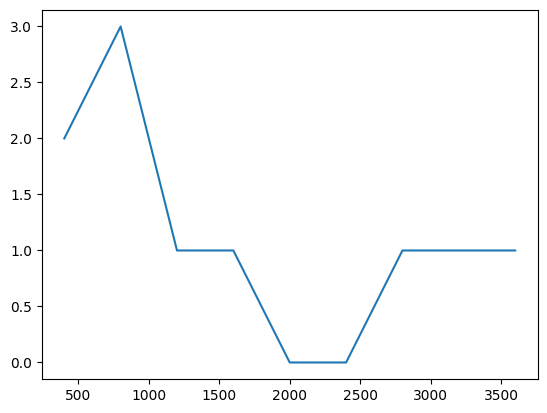

In [31]:
plt.plot(episodes, rewards)

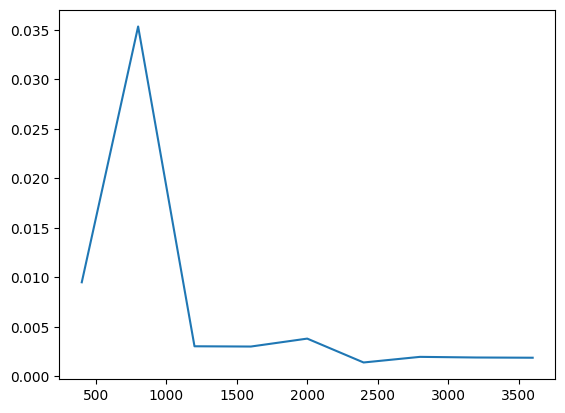

In [32]:
plt.plot(episodes, losses)

### Save model

In [34]:
with open('dqn_model_sgd_1100000.pt', 'wb') as f:
    torch.save(model.state_dict(), f)